In [32]:
import pandas as pd
import numpy as np 

In [33]:
debt_params = pd.read_csv("/Users/ishittaiyer/Desktop/Nielson holdings project/DebtParams.csv")
ops_export = pd.read_csv("/Users/ishittaiyer/Desktop/Nielson holdings project/Export.csv")

In [34]:
debt_params.head()
ops_export.head()

,Period,t,Revenue,EBITDA,DA,CapEx,DeltaNWC,TaxRate,InterestExpense,DebtRepayment,DebtBalance,UFCF,Adj,EquityCF
0,2019A,-1,3441,1323,465,328,0,0%,0,0,0,0,0,0
1,2020A,-1,3361,1217,550,305,-228,0%,0,0,0,0,0,0
2,2021A,-1,3500,1376,512,316,368,0%,0,0,0,0,0,0
3,2022E,0,3676,1623,523,339,-177,41%,591,780,11720,913,25,-4628
4,2023E,1,3936,1810,475,374,-5,40%,550,773,10947,982,16,0


In [ ]:
# constants for now (annual decimals).
SOFR_CONST = 0.0525
EURIBOR_CONST = 0.0375

if "SOFR" not in ops_export.columns:
    ops_export["SOFR"] = SOFR_CONST
if "EURIBOR" not in ops_export.columns:
    ops_export["EURIBOR"] = EURIBOR_CONST


BASE_RATES = {
    "SOFR": SOFR_CONST,
    "EURIBOR": EURIBOR_CONST,
    "FIXED": 0.0  # not really used, but avoids key errors
}

In [36]:
# DebtParams cleaning
debt_params["amortization"] = (
    debt_params["amortization"].astype(str).str.rstrip("%").astype(float) / 100
)
debt_params["fixed_rate"] = (
    debt_params["fixed_rate"].astype(str).str.rstrip("%").astype(float) / 100
)

# Export cleaning
ops_export["TaxRate"] = (
    ops_export["TaxRate"].astype(str).str.rstrip("%").astype(float) / 100
)

# Convert other numeric columns safely
num_cols = ["principal_amount","maturity","OID","spread","commitment"]
debt_params[num_cols] = debt_params[num_cols].apply(pd.to_numeric, errors="coerce")

ops_num_cols = ["Revenue","EBITDA","DA","CapEx","DeltaNWC",
                "InterestExpense","DebtRepayment","DebtBalance",
                "UFCF","Adj","EquityCF"]
ops_export[ops_num_cols] = ops_export[ops_num_cols].apply(pd.to_numeric, errors="coerce")


In [37]:
WATERFALL_RANK = {
    "revolver": 1,
    "firstlienUSD": 2,
    "firstlienEUR": 3,
    "secondlien": 4,
    "seniorsecurednotes": 99,
    "unsecured": 99,
}


In [38]:
# --- Interest rate helper(s) ---


def _get_base_rate(index_name: str, t: int, base_rates: dict) -> float:
    """
    Returns the base rate (SOFR/EURIBOR) for time t.
    base_rates can be:
      - {'SOFR': 0.0325, 'EURIBOR': 0.02}  (flat)
      - {'SOFR': [0.03, 0.031, ...], 'EURIBOR': [ ... ]}  (term structure by t)
    """
    key = str(index_name).upper()
    if key not in base_rates:
        raise KeyError(f"Base rate for index '{index_name}' not provided in base_rates.")
    val = base_rates[key]
    if isinstance(val, (list, tuple, np.ndarray)):
        if t < 0 or t >= len(val):
            # if out of range, use last available
            return float(val[-1])
        return float(val[t])
    return float(val)

def tranche_rate(row: pd.Series, t: int, base_rates: dict) -> float:
    """
    Compute annual coupon rate (decimal) for a tranche at period t.
    Assumptions:
      - If row['index'] == 'Fixed' -> use row['fixed_rate'] (already decimal).
      - Else -> base_rate(index, t) + (row['spread'] in bps)/10,000.
    Expects columns: 'index', 'spread', 'fixed_rate'.
    """
    idx = str(row["index"])
    if idx == "Fixed":
        r = row.get("fixed_rate", np.nan)
        if pd.isna(r):
            raise ValueError(f"Fixed-rate tranche missing fixed_rate: {row.get('tranche_name','<unknown>')}")
        return float(r)
    # floating
    br = _get_base_rate(idx, t, base_rates)
    sp_bps = row.get("spread", 0.0)
    return float(br) + float(sp_bps) / 10000.0


In [ ]:
row = debt_params.iloc[2]
tranche_rate(row, 1, BASE_RATES)

0.065

In [40]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple

def _to_decimal(x):
    if isinstance(x, str) and x.endswith("%"):
        try:
            return float(x.strip("%"))/100.0
        except:
            return np.nan
    return float(x)

def build_debt_roll_and_irr(
    ops_export: pd.DataFrame,
    debt_params: pd.DataFrame,
    base_rates: Dict[str, float],
    priority: List[str],
    exit_multiple: float = 10.3,
) -> Tuple[pd.DataFrame, float, float, float]:
    """
    Uses your existing helpers & inputs:
      - tranche_rate(row, t, base_rates)  # already defined in your nb
      - base_rates dict
      - priority: list of tranche_name strings (cash-sweep order)
      - ops_export columns: t, EBITDA, UFCF, (EquityCF at t=0 optional)
      - debt_params columns: tranche_name, principal_amount, amortization, index/spread/fixed_rate, commitment (revolver)
    Returns: (debt_roll_df, irr, EV_exit, net_debt_exit)
    """
    # robust periodic IRR (avoids np.irr NaNs)
    def irr_bisection(cashflows, low=-0.9999, high=10.0, tol=1e-8, max_iter=200):
        def npv(r):
            return sum(cf / ((1+r)**i) for i, cf in enumerate(cashflows))
        f_low, f_high = npv(low), npv(high)
        if f_low * f_high > 0:
            return np.nan
        for _ in range(max_iter):
            mid = (low + high) / 2
            f_mid = npv(mid)
            if abs(f_mid) < tol:
                return mid
            if f_low * f_mid < 0:
                high, f_high = mid, f_mid
            else:
                low, f_low = mid, f_mid
        return mid

    # forecast periods only
    ops = ops_export.loc[ops_export["t"] >= 0].sort_values("t").reset_index(drop=True)
    tranches = debt_params["tranche_name"].tolist()

    debt = debt_params.copy()
    if "amortization" in debt.columns:
        debt["amortization"] = debt["amortization"].apply(_to_decimal)
    if "fixed_rate" in debt.columns:
        debt["fixed_rate"] = debt["fixed_rate"].apply(_to_decimal)
    if "spread" in debt.columns:
        debt["spread"] = pd.to_numeric(debt["spread"], errors="coerce").fillna(0.0)
    if "commitment" in debt.columns:
        debt["commitment"] = pd.to_numeric(debt["commitment"], errors="coerce").fillna(0.0)

    # opening balances: revolver starts at 0 (draw as needed); others at principal_amount
    balances, limits = {}, {}
    for _, d in debt.iterrows():
        tr = d["tranche_name"]
        principal = float(d.get("principal_amount", 0.0))
        commitment = float(d.get("commitment", 0.0))
        if tr.lower() == "revolver":
            balances[tr] = 0.0
            limits[tr] = commitment if commitment > 0 else principal
        else:
            balances[tr] = principal
            limits[tr] = np.inf

    rows = []
    for _, row_ops in ops.iterrows():
        t = int(row_ops["t"])
        ufcf = float(row_ops["UFCF"])
        ebitda_t = float(row_ops["EBITDA"])

        # 1) interest on opening balances
        total_interest, per_tr_interest = 0.0, {}
        for _, d in debt.iterrows():
            tr = d["tranche_name"]
            opening = balances.get(tr, 0.0)
            if opening <= 0:
                r, interest = 0.0, 0.0
            else:
                r = tranche_rate(d, t, base_rates)   # <- your helper
                interest = opening * r
            per_tr_interest[tr] = interest
            total_interest += interest

        cash_after_int = ufcf - total_interest

        # 2) scheduled amort (as % of current balance — change line if you prefer % of original)
        per_tr_amort = {}
        for _, d in debt.iterrows():
            tr = d["tranche_name"]
            bal = balances[tr]
            amort_pct = float(d.get("amortization", 0.0) or 0.0)
            scheduled = min(bal, bal * amort_pct) if amort_pct > 0 else 0.0
            balances[tr] = bal - scheduled
            per_tr_amort[tr] = scheduled
            cash_after_int -= scheduled

        # 3) revolver draw if negative cash (capped by commitment)
        per_tr_draw = {tr: 0.0 for tr in tranches}
        if cash_after_int < 0 and "revolver" in balances:
            need = -cash_after_int
            rev_bal, rev_limit = balances["revolver"], limits["revolver"]
            can_draw = max(0.0, rev_limit - rev_bal)
            draw = min(need, can_draw)
            balances["revolver"] += draw
            per_tr_draw["revolver"] = draw
            cash_after_int += draw

        # 4) CASH SWEEP — pay down by your priority order
        per_tr_sweep = {tr: 0.0 for tr in tranches}
        if cash_after_int > 0:
            for tr in priority:
                if tr not in balances:
                    continue
                bal = balances[tr]
                if bal <= 0:
                    continue
                pay = min(bal, cash_after_int)
                balances[tr] = bal - pay
                per_tr_sweep[tr] = pay
                cash_after_int -= pay
                if cash_after_int <= 1e-9:
                    break

        rec = {"t": t, "EBITDA": ebitda_t, "UFCF": ufcf,
               "total_interest": total_interest, "fcf_after_debt": cash_after_int}
        for tr in tranches:
            rec[f"{tr}_interest"] = per_tr_interest.get(tr, 0.0)
            rec[f"{tr}_amort"]   = per_tr_amort.get(tr, 0.0)
            rec[f"{tr}_sweep"]   = per_tr_sweep.get(tr, 0.0)
            rec[f"{tr}_draw"]    = per_tr_draw.get(tr, 0.0)
            rec[f"{tr}_closing"] = balances.get(tr, 0.0)
        rows.append(rec)

    debt_roll = pd.DataFrame(rows).sort_values("t").reset_index(drop=True)

    # Exit equity value
    EV_exit = exit_multiple * float(ops.iloc[-1]["EBITDA"])
    net_debt_exit = sum(float(debt_roll.iloc[-1][f"{tr}_closing"]) for tr in tranches)
    equity_exit_value = EV_exit - net_debt_exit

    # Equity CFs: use your EquityCF at t=0 if present; else fallback to negative sum of opening principals
    if "EquityCF" in ops_export.columns and (ops_export["t"] == 0).any():
        eq0 = float(ops_export.loc[ops_export["t"] == 0, "EquityCF"].iloc[0])
    else:
        eq0 = -sum(float(x) for x in debt_params["principal_amount"])

    equity_cfs = [eq0] + [0.0]*(len(ops)-1) + [equity_exit_value]
    irr = irr_bisection(equity_cfs)
    return debt_roll, irr, EV_exit, net_debt_exit


In [41]:
# you already have: ops_export, debt_params, base_rates, priority
debt_roll, irr, EV_exit, net_debt_exit = build_debt_roll_and_irr(
    ops_export, debt_params, BASE_RATES, WATERFALL_RANK, exit_multiple=10.3
)

print("IRR:", irr)
print("Exit EV:", EV_exit)
print("Net Debt @ Exit:", net_debt_exit)

# quick peek:
cols = ["t", "UFCF", "total_interest", "fcf_after_debt"] + [c for c in debt_roll.columns if c.endswith("_closing")]
display(debt_roll[cols].tail())


IRR: 0.26474443689500526
Exit EV: 23906.300000000003
Net Debt @ Exit: 12064.8615625


,t,UFCF,total_interest,fcf_after_debt,firstlienUSD_closing,firstlienEUR_closing,seniorsecurednotes_closing,secondlien_closing,revolver_closing,unsecured_closing
0,0,913.0,1164.750000,0.000000,5082.500000,475.000000,2500.0,2150.0,544.25,2000.0
1,1,982.0,1185.611875,-375.736875,4828.375000,451.250000,2500.0,2150.0,650.00,2000.0
2,2,1169.0,1167.386563,-262.367813,4586.956250,428.687500,2500.0,2150.0,650.00,2000.0
3,3,1336.0,1140.779734,-55.561922,4357.608438,407.253125,2500.0,2150.0,650.00,2000.0


In [42]:
rng = np.random.default_rng(42)  # reproducible

In [43]:
def mu_from_growth_rates(growth_rates, dt=1.0):
    """
    Convert a list/array of growth rates (e.g. 0.0414 for 4.14%)
    into GBM log-drifts μ_t per period.
    
    Returns:
        numpy array of μ_t (one per growth rate)
    """
    gr = np.array(growth_rates, dtype=float)
    mu_series = np.log(1.0 + gr) / dt
    return mu_series

In [44]:
mgmt_growth = [0.0414, 0.0503, 0.0707, 0.0737, 0.0655]  # 4.14%...6.55%
mu_t = mu_from_growth_rates(mgmt_growth)
mu_t

array([0.04056596, 0.04907584, 0.06831264, 0.07111063, 0.06344417])

In [45]:
def mu_from_growth_rates(growth_rates, dt=1.0):
    """
    Convert YoY growth rates (e.g., 0.0414 for 4.14%) into GBM log-drifts μ_t.
    Returns a numpy array aligned to each forward step.
    """
    gr = np.array(growth_rates, dtype=float)
    mu_t = np.log(1.0 + gr) / dt
    return mu_t

In [46]:
def simulate_revenue_gbm_timevarying(R0, mu_t, sigma, dt=1.0, rng=None):
    """
    Simulates revenue path with time-varying log-drifts μ_t and constant σ.
    Returns array of length T+1: [R0, R1, ..., RT].
    """
    rng = rng or np.random.default_rng()
    T = len(mu_t)
    rev = np.empty(T + 1, dtype=float)
    rev[0] = float(R0)

    for t in range(T):
        # GBM discretization: R_{t+1} = R_t * exp((μ_t - 0.5σ^2)Δt + σ√Δt * Z)
        drift = (mu_t[t] - 0.5 * sigma**2) * dt
        shock = sigma * np.sqrt(dt) * rng.standard_normal()
        rev[t+1] = rev[t] * np.exp(drift + shock)

    return rev


In [47]:
def derive_ops_from_revenue(
    t_index,
    revenue,
    ebitda_margin=0.28,       # <- change as needed
    capex_pct_rev=0.035,      # <- change as needed
    d_and_a_pct_rev=0.030,    # <- change as needed
    nwc_pct_of_delta_rev=0.12,# <- change as needed
    tax_rate=0.25,            # <- change as needed (effective cash taxes)
    equity_cf0=None,          # set a number to include EquityCF at t=0 in ops_export
):
    """
    Minimal, consistent ops_export builder for your IRR engine.
    You can swap these formulas to mirror your Excel exactly.
    """
    rev = np.asarray(revenue, dtype=float)
    t = np.asarray(t_index, dtype=int)

    ebitda = ebitda_margin * rev
    d_and_a = d_and_a_pct_rev * rev
    capex  = capex_pct_rev * rev

    # ΔNWC ~ % * ΔRevenue (set first period to 0 by convention)
    d_rev = np.diff(rev, prepend=rev[0])
    delta_nwc = nwc_pct_of_delta_rev * d_rev
    delta_nwc[0] = 0.0

    ebit = ebitda - d_and_a
    taxable_income = np.maximum(0.0, ebit)   # adjust if you model NOLs
    cash_taxes = tax_rate * taxable_income

    # Unlevered FCF (no interest here)
    ufcf = ebitda - capex - delta_nwc - cash_taxes

    ops = pd.DataFrame({
        "t": t,
        "Revenue": rev,
        "EBITDA": ebitda,
        "UFCF": ufcf,
    })
    if equity_cf0 is not None:
        ops.loc[ops["t"] == t[0], "EquityCF"] = float(equity_cf0)
    return ops

In [49]:
def build_single_ops_from_mgmt_growth(
    R0,
    mgmt_growth_rates,
    sigma=0.12,         # <<< CHANGE σ HERE (annualized volatility)
    dt=1.0,
    seed=42,
    ebitda_margin=0.28,
    capex_pct_rev=0.035,
    d_and_a_pct_rev=0.030,
    nwc_pct_of_delta_rev=0.12,
    tax_rate=0.25,
    equity_cf0=None,
):
    """
    Returns (ops_export_df, revenue_df) for a single simulated path.
    revenue_df has columns ['t','Revenue'] exactly as you requested.
    """
    rng = np.random.default_rng(seed)
    mu_t = mu_from_growth_rates(mgmt_growth_rates, dt=dt)
    rev_path = simulate_revenue_gbm_timevarying(R0, mu_t, sigma, dt=dt, rng=rng)

    # time index t=0..T
    t_index = list(range(len(rev_path)))

    # Revenue-only DF (your requested format)
    revenue_df = pd.DataFrame({"t": t_index, "Revenue": rev_path})

    # Full ops_export (for your IRR function)
    ops_export = derive_ops_from_revenue(
        t_index=t_index,
        revenue=rev_path,
        ebitda_margin=ebitda_margin,
        capex_pct_rev=capex_pct_rev,
        d_and_a_pct_rev=d_and_a_pct_rev,
        nwc_pct_of_delta_rev=nwc_pct_of_delta_rev,
        equity_cf0=-4628,
        tax_rate=tax_rate,
    
    )
    return ops_export, revenue_df


In [65]:
def run_mc_irrs_from_mgmt_growth(
    build_debt_roll_and_irr_fn,  # pass your function object here
    debt_params: pd.DataFrame,
    base_rates: dict,
    priority: list,
    R0: float,
    mgmt_growth_rates,
    exit_multiple_base=10.3,
    n_paths=2000,
    sigma=0.2,        # <<< CHANGE σ HERE for MC
    dt=1.0,
    seed=42,
    equity_cf0=None,
    # ops assumptions (keep aligned with single-run helper)
    ebitda_margin=0.28,
    capex_pct_rev=0.035,
    d_and_a_pct_rev=0.030,
    nwc_pct_of_delta_rev=0.12,
    tax_rate=0.25,
):
    rng = np.random.default_rng(seed)
    mu_t = mu_from_growth_rates(mgmt_growth_rates, dt=dt)
    T = len(mu_t)

    irrs = np.empty(n_paths)
    ev_exits = np.empty(n_paths)
    net_debts = np.empty(n_paths)

    for i in range(n_paths):
        rev_path = simulate_revenue_gbm_timevarying(R0, mu_t, sigma, dt=dt, rng=rng)
        t_index = list(range(T+1))
        ops_export = derive_ops_from_revenue(
            t_index=t_index,
            revenue=rev_path,
            ebitda_margin=ebitda_margin,
            capex_pct_rev=capex_pct_rev,
            d_and_a_pct_rev=d_and_a_pct_rev,
            nwc_pct_of_delta_rev=nwc_pct_of_delta_rev,
            equity_cf0=equity_cf0,
            tax_rate=tax_rate,
        )

        debt_roll, irr, EV_exit, net_debt_exit = build_debt_roll_and_irr_fn(
            ops_export=ops_export,
            debt_params=debt_params,
            base_rates=base_rates,
            priority=priority,
            exit_multiple=exit_multiple_base,  # keep fixed first; add randomness later if needed
        )
        irrs[i] = irr
        ev_exits[i] = EV_exit
        net_debts[i] = net_debt_exit

    return pd.DataFrame({"IRR": irrs, "EV_exit": ev_exits, "NetDebt_exit": net_debts})


In [67]:
# 0) Inputs you already have
R0 = 3500.0  # replace with your latest actual revenue (same units as Excel)
mgmt_growth = [0.0414, 0.0503, 0.0707, 0.0737, 0.0655]  # your mgmt rates
sigma_choice = 0.1  # <<< tweak this (e.g., 0.08, 0.12, 0.18)

# 1) Build a single path and get the two DFs you wanted
ops_export, revenue_df = build_single_ops_from_mgmt_growth(
    R0=R0,
    mgmt_growth_rates=mgmt_growth,
    sigma=sigma_choice,         # <<< change σ here for single run
    equity_cf0=None,            # or set to your opening equity (negative)
    ebitda_margin=0.54,         # align with your Excel
    capex_pct_rev=0.095,
    d_and_a_pct_rev=0.13,
    nwc_pct_of_delta_rev=-0.33,
    tax_rate=0.44,
)

# revenue_df has columns ["t", "Revenue"]; ops_export has t/Revenue/EBITDA/UFCF (and EquityCF if set)

# 2) Run your IRR engine on the single path
# debt_params, base_rates, priority must already be defined in your notebook
debt_roll, irr, EV_exit, net_debt_exit = build_debt_roll_and_irr(
    ops_export=ops_export,
    debt_params=debt_params,
    base_rates=BASE_RATES,
    priority=WATERFALL_RANK,
    exit_multiple=10.3,  # keep fixed initially
)

print("Single-path IRR:", irr)

# 3) Monte Carlo distribution of IRR (many revenue paths)
mc = run_mc_irrs_from_mgmt_growth(
    build_debt_roll_and_irr_fn=build_debt_roll_and_irr,
    debt_params=debt_params,
    base_rates=BASE_RATES,
    priority=WATERFALL_RANK,
    R0=R0,
    mgmt_growth_rates=mgmt_growth,
    exit_multiple_base=10.3,
    n_paths=5000,
    sigma=sigma_choice,          # <<< only randomness difference
    dt=1.0,
    seed=42,
    equity_cf0=-4628,            # <<< your Excel equity check
    ebitda_margin=0.54,
    capex_pct_rev=0.095,
    d_and_a_pct_rev=0.13,
    nwc_pct_of_delta_rev=-33,
    tax_rate=0.44,
)
print(mc["IRR"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))


Single-path IRR: 0.16258915759599407
count    5000.000000
mean        0.324003
std         0.065606
min        -0.188968
5%          0.231313
25%         0.293509
50%         0.327976
75%         0.362585
95%         0.414920
max         0.553548
Name: IRR, dtype: float64


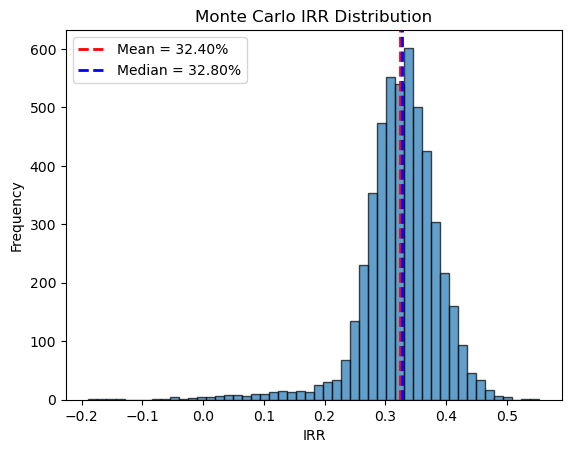

In [68]:
import matplotlib.pyplot as plt

plt.hist(mc["IRR"], bins=50, edgecolor="black", alpha=0.7)
plt.title("Monte Carlo IRR Distribution")
plt.xlabel("IRR")
plt.ylabel("Frequency")
plt.axvline(mc["IRR"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean = {mc['IRR'].mean():.2%}")
plt.axvline(mc["IRR"].median(), color="blue", linestyle="dashed", linewidth=2, label=f"Median = {mc['IRR'].median():.2%}")
plt.legend()
plt.show()


In [69]:
# choose your confidence levels
for alpha in [0.01, 0.05, 0.10]:
    var = mc["IRR"].quantile(alpha)
    print(f"VaR {alpha*100:.0f}%: {var:.2%}")


VaR 1%: 7.44%
VaR 5%: 23.13%
VaR 10%: 26.15%


In [70]:
alpha = 0.05
cvar = mc["IRR"][mc["IRR"] <= mc["IRR"].quantile(alpha)].mean()
print(f"CVaR {alpha*100:.0f}% (Expected Shortfall): {cvar:.2%}")


CVaR 5% (Expected Shortfall): 13.83%


In [89]:
hurdle = 0.20  # e.g., 20% IRR target
downside_prob = (mc["IRR"] < hurdle).mean()
var_5  = mc["IRR"].quantile(0.05)
cvar_5 = mc.loc[mc["IRR"] <= var_5, "IRR"].mean()

print(f"Pr[IRR < {hurdle:.0%}] = {downside_prob:.1%}")
print(f"VaR(5%) = {var_5:.2%}")
print(f"CVaR(5%) = {cvar_5:.2%}")


Pr[IRR < 20%] = 3.6%
VaR(5%) = 23.13%
CVaR(5%) = 13.83%
